## introduction ##
In 2018, Jun-Yan Zhu, Taesung Park, Phillip Isola Alexei and A. Efros presented a paper called "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks"  [here](https://arxiv.org/pdf/1703.10593.pdf). The objective is to transfer an image from a domain X to a domain Y, for instance day to night or apple to orange. More precisely, they present an approach for learning to translate an image from a source domain X to a target domain Y in the absence of paired examples. This is innteresting as collecting a dataset of paired images is not an easy task. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./imgs/paired.png",width=300, height=100)

# 1. CycleGan architecture#
The architecture is very similar to the one we used in DiscoGan paper [in previous jupyter](https://github.com/john7002/DISCO-GAN/blob/master/Exploring%20cross%20domains%20relations%20with%20DiscoGAN.ipynb): 2 Generators, 2 discrimators and a cycle loss, which is actually how to get back to the initial image : 

In [2]:
Image(url= "./imgs/architecture.png",width=500, height=250)

We will hence implement:
* 2 generators G<sub>XY</sub> and F<sub>YX</sub>
* 2 discrimators D<sub>Y</sub> (looking to discern between y and generated images G(x)) and D<sub>X</sub> (looking to discern between x and generated images F(y))
* the cycle-consistency loss which is how close the generated y<sub>2</sub> in  G<sub>XY</sub>(F<sub>YX</sub>(y))=y<sub>2</sub> is close to initial image y.

At the end the total loss L = L<sub>GAN</sub>(G,D<sub>y</sub>,X,Y) + L<sub>GAN</sub>(F,D<sub>x</sub>,Y,X) + λ. L<sub>cycle</sub>(G,F)
where λ give importance to the cycle-consistency loss.

# 1. CycleGan architecture#
They adopt the architecture for our generative networks from Johnson et al. [23] who have
shown impressive results for neural style transfer and super-resolution. This network contains two stride-2 convolu-
tions, several residual blocks, and two fractionally-strided convolutions with stride 1 . They use 6 blocks for 2
128 × 128 images and 9 blocks for 256 × 256 and higher- resolution training images.We will use instance normalization. For the discriminator networks we use 70 × 70 PatchGANs, which aim to classify whether 70 × 70 overlapping image patches are real or fake. Such a patch-level discriminator architecture has fewer parameters than a full-image discriminator and can work on arbitrarily-sized images in a fully convolutional fashion 

## 1.1 Generator class ##
Let's implement a class to create two generators and try to train with the Monet2Photo dataset(256x256). We will use 9 residual blocks. The network with 9 residual blocks consists of:<br>

<div style = "background-color:lightgrey; width:600px; height:50px; line-height:50px;">
    <i><center> c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3</center></i>
</div>

As noted in the paper, we will use the notation from Johnson et al. Let c7s1-k denote a 7 × 7 Convolution-InstanceNorm- ReLU layer with k filters and stride 1. dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. Reflection padding was used to reduce artifacts. Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer. uk denotes a 3 × 3 fractional-strided-Convolution- InstanceNorm-ReLU layer with k filters and stride 2 .
Graphically, it looks like this:

<img src="./imgs/cyclegan-gen.png" width="850" height="400">

The network needs 9 residual blocks. To do so, we need to declare a class ResnetBlock which is just a sum (made in the forward method) of the input layer and the l+2 layer as defined in the image below. These blocks are efficient to decrease the vaninshing gradient.


In [3]:
Image(url= "./imgs/resnet.png",width=500, height=250)


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import numpy as np
from torch.autograd.variable import Variable
import torch

In [5]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, use_dropout):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
"""       
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, use_dropout)

    def build_conv_block(self, dim, use_dropout):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0), nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

And here is the generator:

In [6]:
picture_nb_chanels = 3
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu # number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs
        
        self.main = nn.Sequential(
            
            nn.ReflectionPad2d(3), # reflection padding for artifact => create 256+3+3 x 256+3+3 images
            # 1st convolution layer, input image is 262x262x3, c7s1-64: 64 filter 7x7, stride 1, instanceNorm+Relu
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=7,stride =1,padding = 0),  
            #padding = 0 (valid) =>  out = n-f+1 = 262 - 7 + 1 = 256
            nn.InstanceNorm2d(64),
            nn.ReLU(), #out is -1,64,256,256   
            
            
            # 2nd convolution layer, d128 same as previous with 128 kernels of size 3 and stride 2
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride =2,padding = 1),  
            #out: (n+2p-f)/2 +1 => 256+2-3 /2 +1 = 128,5 = 128 ( take the round)
            nn.InstanceNorm2d(128),
            nn.ReLU(), #out is -1,128,128,128
            
            # 3rd convolution layer, d256 same as previous with 256
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride =2,padding = 1),  
            #out: (n+2p-f)/2 +1 => 128+2-3 /2 +1 = 64,5 = 64
            nn.InstanceNorm2d(256),
            nn.ReLU(), #out is -1,256,64,64  
            
            # 9 Resnet block R256: two 3 × 3 convolutional layers with the same number of filters on both layer
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            ResnetBlock(256,use_dropout=0),
            
            #1st T_convolution layer u128 denotes a 3 × 3 fractional-strided-Convolution- InstanceNorm-ReLU layer with 128 filters and stride 1
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias = False,output_padding=1),
            # The output of convTranspose2d is o = (i -1)*s - 2*p + f + output_padding => (64-1)*2 - 2*1 + 3 +1 = 128 
            nn.InstanceNorm2d(128),
            nn.ReLU(), #out is -1,128,128,128
            
            #2nd T_convolution layer u64 
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias = False,output_padding=1),
            # The output of convTranspose2d is o = (i -1)*s - 2*p + f + output_padding => (128-1)*2 - 2*1 + 3 +1 = 256 
            nn.InstanceNorm2d(128),
            nn.ReLU(), #out is -1,64,256,256
            
            
            nn.ReflectionPad2d(3), # reflection padding for artifact => create 256+3+3 x 256+3+3 images
            
            #Last convolution layer c7s1-3 : 3 filters 7x7, stride1
            nn.Conv2d(in_channels=64, out_channels=3,kernel_size=7,stride =1,padding = 0),  
            #padding = 0 (valid) =>  out = n-f+1 = 262 - 7 + 1 = 256
            nn.InstanceNorm2d(64),
            nn.Tanh(), #out is -1,3,256,256   
            
            
            
        )
    def forward(self, input):
        return self.main(input)
        
        
   
net = Generator(ngpu=0)
#net.cuda() if compiled with gpu

summary(net, ( 3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

Regarding reflectionPad, here is an example on how it works

In [7]:
m = nn.ReflectionPad2d(2)
import torch
input = torch.arange(9, dtype=torch.float).reshape(1, 1, 3, 3)
print(input)
m(input)

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])


tensor([[[[8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.],
          [5., 4., 3., 4., 5., 4., 3.],
          [8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.]]]])

Let's try to generate a picture with a real image as input :

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


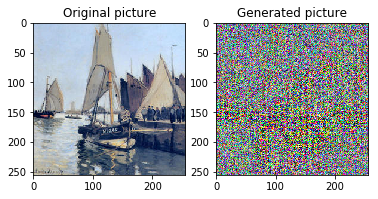

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


from PIL import Image
import torchvision.transforms.functional as TF

image = Image.open("./monet2photo/trainA/00596.jpg")
x = TF.to_tensor(image)
x.unsqueeze_(0)
print(x.shape)

gen = Generator(0)
generated_images = gen(x)
print(generated_images[0].shape)
trans = transforms.ToPILImage()
pic = trans(generated_images[0])

#generated_images = generated_images.detach().numpy()

#print(pic.shape)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original picture')

plt.subplot(1, 2, 2)
plt.imshow(pic)
plt.title('Generated picture')
plt.show()

Great, we have the generator ready!

## 1.2 Discriminator ##

For discriminator networks, we use 70 × 70 PatchGAN. Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2. After the last layer, we apply a convo- lution to produce a 1-dimensional output. We do not use InstanceNorm for the first C64 layer. We use leaky ReLUs with a slope of 0.2. The discriminator architecture is:
<div style = "background-color:lightgrey; width:400px; height:50px; line-height:50px;">
    <i><center> C64-C128-C256-C512</center></i>
</div>

<img src="./imgs/cyclegan_disc.png" width="850" height="350">

In [9]:
picture_nb_chanels = 1
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu # number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs
        self.main = nn.Sequential(
        
        # 1st convolution layer C64
        nn.Conv2d(in_channels=3, out_channels=64,kernel_size=4,stride =2,padding = 1),  
        #out: (n+2p-f)/2 +1 => (256 +2*1 -4) /2 +1 = 31/2 +1 = 128
        #nn.InstanceNorm2d(128), no norm on 1st layer
        nn.LeakyReLU(0.02), #out is -1,64,128,128    
    
        # 2nd convolution layer C128
        nn.Conv2d(in_channels=64, out_channels=128,kernel_size=4,stride =2,padding = 1),  
        #out: (n+2p-f)/2 +1 => (128 +2*1 -4) /2 +1 = 31 +1 = 64
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.02), #out is -1,128,64,64
            
        # 3nd convolution layer C256
        nn.Conv2d(in_channels=128, out_channels=256,kernel_size=4,stride =2,padding = 1),  
        #out: (n+2p-f)/2 +1 => (64 +2*1 -4) /2 +1 = 32
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.02), #out is -1,256,32,32
            
        # 4th convolution layer C512
        nn.Conv2d(in_channels=256, out_channels=512,kernel_size=4,stride =1,padding = 1),  
        #out: (n+2p-f)/s +1 => (32 +2*1 -4) /1 +1 = 31
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.02), #out is -1,512,31,31
            
        nn.ZeroPad2d((1, 0, 1, 0)), # add a pading to get in final layer 16x16 patchgan
            
           
        nn.Conv2d(in_channels=512, out_channels=1,kernel_size=4,stride =2,padding = 1),
            #out: (n+2p-f)/s +1 => (32 +2*1 -4) /2 +1 = 16
        )
        
    def forward(self, input):
        return self.main(input)
    
net = Discriminator(ngpu=0)

summary(net, ( 3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
        ZeroPad2d-12          [-1, 512, 32, 32]               0
           Conv2d-13            [-1, 1, 16, 16]           8,193
Total params: 2,764,737
Trainable param

## 1.3 Weight intialisation ##

In the paper, weights are initialized from a Gaussian distribution N(0, 0.02). We will finally try Kaiming for convolutional layer.

In [10]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        #init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
   

# 2. Training implementation#

As a reminder, our model is composed of 2 generators and 2 discriminators.
We have one domain called X ( Monet drawings), and one target domain Y ( real pictures).
We have 2 generators and 2 discriminators:
<lu>
    <li> $G_{XY}$: tranfer image from domain X to domain Y
    </li>
    <li> $G_{YX}$: tranfer image from domain Y to domain X
    </li>
    <li> $D_{X}$: Discriminator to discern real X of fake X ($G_{YX}$)
    </li>
    <li> $D_{Y}$: Discriminator to discern real Y of fake Y ($G_{XY}$)
    </li>
</lu>

We are going to implement several losses:
<lu>
    <li> One adversial loss: L<sub>GAN</sub>(G<sub>XY</sub>,D<sub>Y</sub>,X,Y), in the paper they use least-square loss (L2) which is as they say <i>more stable during training and generates higher quality results</i>. $$Loss_GXY = \frac{1}{m}\sum_{i=1}^{m}(1-D_{Y}(G_{XY}(X))^2$$
    </li>
    <li> One adversial loss: L<sub>GAN</sub>(G<sub>YX</sub>,D<sub>X</sub>,X,Y): $$Loss_GYX = \frac{1}{m}\sum_{i=1}^{m}(1-D_{X}(G_{YX}(Y))^2$$
    </li>
    </lu>
    
   However, the adversarial loss alone is not sufficient to produce good images, as it leaves the model under-constrained. The cycle consistency loss addresses this issue. It relies on the expectation that if you convert an image to the other domain and back again, by successively feeding it through both generators, you should get back something similar to what you put in. It enforces that $G_{YX}(G_{XY}(X)) ≈ x$ and $G_{XY}(G_{YX}(Y)) ≈ y$. In the paper, L1 loss is used.
   <lu>
    <li>
        $$LossCycleX = \frac{1}{m}\sum_{i=1}^{m}(G_{YX}(G_{XY}(X)) - X_{i})$$
    </li>
    <li>
        $$LossCycleY = \frac{1}{m}\sum_{i=1}^{m}(G_{XY}(G_{YX}(Y)) - Y_{i})$$
        </li>
     </li>
    </lu>

The full objective is hence the sum of all previous loss: $LFull = Loss_GXY + Loss_GYX + \lambda(LossCycleX + LossCycleY)$ where $\lambda$ controls the relative importance of the two objectives.

So far, except the $\lambda$ term just introduced, the whole process is very close to DiscoGan architecture, but after further reading of the paper, they also intriduced another loss: the identity. <i> For painting→photo, we find that it is helpful to introduce an additional loss to encourage the mapping to preserve color composition between the input and output. In particular, we adopt the technique of Taigman et al. [49] and regularize the generator to be near an identity mapping when real samples of the target domain are provided as the input to the generator. </i> Here is a benchmark from the paper that clearly shows it helps keeping original color and texture.


        

<img src="./imgs/identity.png" width="380" height="200">

<lu>
    <li>
        $$LossIdentityX = \frac{1}{m}\sum_{i=1}^{m}((G_{YX}(X)) - X_{i})$$
    </li>
    <li>
    $$LossIdentityY = \frac{1}{m}\sum_{i=1}^{m}((G_{XY}(Y)) - Y_{i})$$
    </li>
</ul>


the loss is finally $LFull = Loss_GXY + Loss_GYX + \lambda_1(LossCycleX + LossCycleY) + \lambda_2(LossIdentityX + LossIdentityY) $

## 2.1 Single implementation ##

In [11]:
batch_size = 1
Generator_XY = Generator(0)
Generator_YX = Generator(0)
Discriminator_X = Discriminator(0)
Discriminator_Y = Discriminator(0)

Generator_XY.apply(weights_init)
Generator_YX.apply(weights_init)
Discriminator_X.apply(weights_init)
Discriminator_Y.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.02)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.02)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.02)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.02)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [12]:
# Losses
Loss_GAN = torch.nn.MSELoss()
Loss_cycle = torch.nn.L1Loss()
Loss_identity = torch.nn.L1Loss()

In [13]:
# create real & fake for patchgan, we set output of discriminator to 16x16
valid = Variable(torch.ones(16,16),requires_grad=False)
fake = Variable(torch.zeros(16,16), requires_grad=False)

In paper it is mentionned <i>We train our networks from scratch, with a learning rate of 0.0002. In practice, we divide the objective by 2 while optimizing D, which slows down the rate at which D learns, relative to the rate of G. We keep the same learning rate for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs.</i>

In [14]:
from torch.optim import lr_scheduler

def update_lr(epoch):
    if epoch<101:
        learning_rate = 0.0002
    else:
        learning_rate = (0.0002*((200.0-float(epoch))/100.0))
            #lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
    return learning_rate



#torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

In [15]:
import itertools
# the paper mentions the usage of Adam optimizer
optimizer_G = torch.optim.Adam(
    itertools.chain(Generator_XY.parameters(), Generator_YX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = torch.optim.Adam(Discriminator_X.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D_Y = torch.optim.Adam(Discriminator_Y.parameters(), lr=0.002, betas=(0.5, 0.999))



scheduler_G = lr_scheduler.LambdaLR(optimizer_G, lr_lambda=update_lr)
scheduler_D_X = lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=update_lr)
scheduler_D_Y = lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=update_lr)

Let's create a dataloader of pictures:

In [16]:
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms


# Image transformations
transforms_set = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


train_set = datasets.ImageFolder(root="./monet2photo/",transform=transforms_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)


In [17]:
print(train_set.classes) # testA -> label 0 ; testB -> label 1

['testA', 'testB', 'trainA', 'trainB']


We created a dataloader containing the full sets of images (train and test). We are now subdivise in 4 dataloaders containing test and train from domain X and Y.

In [18]:
def get_indices(dataset,class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
    return indices


idx = get_indices(train_set, 0) # get only picture from testA folder
dataloader_testX = torch.utils.data.DataLoader(train_set,batch_size=1, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))

idx = get_indices(train_set, 1) # get only picture from testB folder
dataloader_testY = torch.utils.data.DataLoader(train_set,batch_size=1, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))

idx = get_indices(train_set, 2) # get only picture from trainA folder
dataloader_trainX = torch.utils.data.DataLoader(train_set,batch_size=1, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))

idx = get_indices(train_set, 3) # get only picture from trainB folder
dataloader_trainY = torch.utils.data.DataLoader(train_set,batch_size=1, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))



Just for information:

In [19]:
print(f"Pictures in train set from Monet pictures (X): {len(dataloader_trainX)}")
print(f"Pictures in train set from real pictures (Y): {len(dataloader_trainY)}")
print(f"Pictures in test set from Monet pictures (X): {len(dataloader_testX)}")
print(f"Pictures in test set from real pictures (Y): {len(dataloader_testX)}")

Pictures in train set from Monet pictures (X): 1072
Pictures in train set from real pictures (Y): 6287
Pictures in test set from Monet pictures (X): 121
Pictures in test set from real pictures (Y): 121


here is how to iterate over two dataloader of different size:

In [20]:
from itertools import cycle


#will stop when smaller dataloader reach its last element
for i, data in enumerate(zip(dataloader_trainX, dataloader_trainY)):
    next
print(i)

#will stop when last element of bigger dataloader is reached using cycle over smaller dataloader
for i, data in enumerate(zip(cycle(dataloader_trainX), dataloader_trainY)):
    next
    
print(i)

1071
6286


A single implementation would be:
- Get a real image true_X from X dataset.
- Get a real image true_Y from Y dataset.
- Generate fake_Y => Generator_XY(X)
- Generate fake_XX => Generator_YX(Y)
- Calculate gan_loss(discriminator_Y(fake_Y,1)) and gan_loss(discriminator_X(fake_X,1)), fake the dsicriminators..
- Calculate cycle_loss(GeneratorXY(Fake_X),true_Y) and cycle_loss(GeneratorYX(Fake_Y),true_X)
- Calculate identity_loss(Generator_XY(true_X),true_X) and identity_loss(Generator_YX(true_Y),true_Y)
- Cumulate all previous loss calculated and train Generator_XY and Generator_YX
- Train Dicsriminator_X and DiscriminatorY will loss_real(discriminator_X(true_X),1) and loss_fake(discriminator_X(fake_X),0)


The pool of image is also specific to the paper, here are the instructions:<i>To reduce model oscillation (...) we update the discriminators using a history of generated images rather than the ones produced by the latest generators. We keep an image buffer that stores the 50 previously created images.</i>

In [21]:
from random import *

# return the current images if the list of previousely creates images are <50
# return a random image if list of stored images is >=50 and store the image in parameter.
def manage_generated_images(generated_batch,image):
    if (len(generated_batch)<50):
        generated_batch.append(image)
        select = image
    elif (random()<0.5):
        select = image
    else:
        idx = randint(0,len(generated_batch)-1)
        select = generated_batch[idx] 
        generated_batch[idx]=image # replace existing image
    return select
        
generated_batch = list()




## 2.2 Full training ##

We need, at specified interval, generate picture to X and Y domain to check how the training is doing, saving the models periodically is also a good thing.

In [23]:
from torchvision.utils import save_image, make_grid
#from google.colab import files

def sample_images(batch,epoch):
    
    dataloader_testX
    dataloader_testY
    
    
    pic_X = next(iter(dataloader_testX)) # will return a random picture from the dataloader, see https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images
    pic_Y = next(iter(dataloader_testY))
    Generator_XY.eval()
    Generator_YX.eval()
    
    real_X = Variable(pic_X[0])
    real_X=real_X.to(0)

    fake_Y = Generator_XY(real_X)
                      
    real_Y = Variable(pic_Y[0])
    real_Y=real_Y.to(0)
    fake_X = Generator_YX(real_Y)
    
    
    real_X = make_grid(real_X, nrow=5, normalize=True)
    real_Y = make_grid(real_Y, nrow=5, normalize=True)
    fake_X = make_grid(fake_X, nrow=5, normalize=True)
    fake_Y = make_grid(fake_Y, nrow=5, normalize=True)
    image_grid = torch.cat((real_X, fake_Y, real_Y, fake_X), 1)
    save_image(image_grid, "result_e%d_b%d.png"%(epoch,batch), normalize=False)
    files.download("./result_e%d_b%d.png"%(epoch,batch))

In [43]:
def save_models(batch,epoch):
    torch.save(Generator_XY.state_dict(), "./Generator_XY_e%d_b%d.pth" % (epoch, batch))
    torch.save(Generator_YX.state_dict(), "./Generator_YX_e%d_b%d.pth" % (epoch, batch))
    torch.save(Discriminator_X.state_dict(), "./Discriminator_X_e%d_b%d.pth" % (epoch, batch))
    torch.save(Discriminator_Y.state_dict(), "./Discriminator_Y_e%d_b%d.pth" % (epoch, batch))

In [24]:
nb_epoch = 200
lambda1=10
lambda2=5 # as noted in paper

batch_fake_X = list()
batch_fake_Y = list()

for epoch in range(nb_epoch):
    for i, data in enumerate(zip(cycle(dataloader_trainX), dataloader_trainY)):
        
        true_X = Variable(data[0][0])
        true_Y = Variable(data[1][0])
         
        #train generator -------------
        optimizer_G.zero_grad()
        # GAN loss ----------
        fake_X = Generator_YX(true_Y)
        loss_GAN_X = Loss_GAN(Discriminator_X(fake_X), valid)
        
        fake_Y = Generator_XY(true_X)
        loss_GAN_Y = Loss_GAN(Discriminator_Y(fake_Y), valid)
        
        total_loss_gan = 0.5*(loss_GAN_X+loss_GAN_Y)
        #-----------------
        
        # cycle loss -------
        recov_X = Generator_YX(fake_Y)
        loss_cycle_X = Loss_cycle(recov_X, true_X)
        
        recov_Y = Generator_XY(fake_X)
        loss_cycle_Y = Loss_cycle(recov_Y, true_Y)
        
        total_cycle_loss = 0.5 * (loss_cycle_X + loss_cycle_Y)
        # -------------------
        
        
        # identity loss -------
        loss_id_X = Loss_identity(Generator_YX(true_X), true_X)
        
        loss_id_Y = Loss_identity(Generator_XY(true_Y), true_Y)
        
        total_id_loss = 0.5 * (loss_id_X + loss_id_Y)
        #----------------------
        
        total_loss = total_loss_gan + lambda1*total_cycle_loss + lambda2*total_id_loss
        
        total_loss.backward()
        optimizer_G.step()
        
        
        
        #train discriminators ------
        optimizer_D_X.zero_grad()
        #optimizer_D_Y.zero_grad()
        
        # get picture from fake pools so that discriminators will not improve too much compare to generators
        fake_X_2 = manage_generated_images(batch_fake_X,fake_X)
        fake_Y_2 = manage_generated_images(batch_fake_Y,fake_Y)
        
        # train discriminator on real and fake
        loss_real_X = Loss_GAN(Discriminator_X(true_X), valid)
        loss_real_Y = Loss_GAN(Discriminator_Y(true_Y), valid)
        
        loss_fake_X = Loss_GAN(Discriminator_X(fake_X_2.detach()), fake) #detach the variable from its origin graph is needed otherwise error
        loss_fake_Y = Loss_GAN(Discriminator_Y(fake_Y_2.detach()), fake)             
        # Total loss
        total_loss_D_X = 0.5*(loss_real_X + loss_fake_X)
        total_loss_D_Y = 0.5*(loss_real_Y + loss_fake_Y)   
        
        
        # backpropagation
        total_loss_D_X.backward()
        optimizer_D_X.step()
        
        total_loss_D_Y.backward()
        optimizer_D_Y.step()
        
        # Print log
        print(f"\r[Epoch {epoch}/{nb_epoch}] [Batch {i}] [total_loss_gan: {total_loss_gan}] [total_id_loss: {total_id_loss}] [total_cycle_loss: {total_cycle_loss}] [total_loss_D_X: {total_loss_D_X}] [total_loss_D_Y: {total_loss_D_Y}]")
        
        if (i%30==0):
            sample_images(i,epoch)
            
        if (i%500==0):
            save_models(i,epoch)
        
        if i==0:
            break
    
    # Update learning rates
    scheduler_G.step()
    scheduler_D_X.step()
    scheduler_D_Y.step()
    
        
        
        
        
        
        
        
        
        

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([16, 16])) that is different to the input size (torch.Size([1, 1, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 0/1] [Batch 0] [total_loss_gan: 2.6127943992614746] [total_id_loss: 0.5821866393089294] [total_cycle_loss: 0.6063520908355713] [total_loss_D_X: 1.8399322032928467] [total_loss_D_Y: 1.7634313106536865]
